# Library

In [1]:
import pandas as pd
import numpy as np
import os
import re
import collections
import unidecode
#from gensim.parsing.preprocessing import remove_stopwords
import nltk
from nltk.corpus import stopwords
import itertools 
from nltk.tokenize import word_tokenize
from string import punctuation

#from nltk import ngrams

#from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfTransformer

In [2]:
import numpy as np

#import tensorflow_datasets as tfds
#import tensorflow as tf

#from tensorflow.keras import preprocessing
#from tensorflow.keras import layers

#tfds.disable_progress_bar()

In [3]:
#from tensorflow.keras import losses
#from tensorflow.keras import preprocessing
#from tensorflow.keras import utils
#from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

#import tensorflow_datasets as tfds
#import tensorflow_text as tf_text

In [4]:
pd.set_option('display.max_colwidth', 100)

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt

In [6]:
from functools import reduce

# Functions

In [7]:
def read_texts(path):
    data = []
    file_name = os.listdir(path)

    for name in file_name:
        if name.endswith('.txt'):
            with open(path + name,encoding="utf8") as f:
                text = f.read()
                data.append({'nombre':name.replace('.txt',''), 'texto':text})

    df = pd.DataFrame(data)
    return df

In [8]:
def clean_text(string):
    """
    A method to clean text 
    """
    
    # Removing the punctuations
    for x in string.lower(): 
        if x in punctuation:
            if x != '/':
                string = string.replace(x, "")
            else:
                string = string.replace(x, " ")
    
    string = unidecode.unidecode(string)

#     # Converting the text to lower
#     string = string.lower()

    # Removing stop words
    string = ' '.join([word for word in string.split() if word not in swords])

    # Cleaning the whitespaces
    string = re.sub(r'\s+', ' ', string).strip()

    return string 

In [9]:
nltk.download('stopwords')
swords = list(set(stopwords.words('spanish')))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/egarcia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
def sep_num_text(data):

    words = word_tokenize(data) 
    for w in words:
        if re.search(r'\d', w):
            ind = words.index(w)
            words[ind] = [''.join(g) for k, g in itertools.groupby(w, str.isalpha)]
    data = ' '.join([x if type(x) is not list else ' '.join(x) for x in words])
    
    return data

In [11]:
def get_f_b_context_text(data):
    
    '''Return context in a string format'''
    
    all_data = []
    sf_not_found = []
    
    for instance in data:
           
        texto = instance['texto']    
        target_word = instance['short_form'] 
        
        if target_word in texto:

            stop_ini_idx = instance['StartOffset'] #índice del inicio de la target
            stop_fin_idx = instance['EndOffset'] #índice del inicio de la target

            _instance = []
            xf = texto[:stop_ini_idx] + ' <start> ' +texto[stop_ini_idx:stop_fin_idx] + ' <end> ' #palabras anteriores a la target
            #xf = texto[:stop_ini_idx] +texto[stop_ini_idx:stop_fin_idx]
            xb = texto[stop_fin_idx+1:]   #palabras posteriores a la target            

            instance_id = instance['long_form'] #id del significado

            _instance.append(target_word)
            _instance.append(xf)
            _instance.append(xb)
            _instance.append(instance_id)

            all_data.append(_instance[:])
        else:
            sf_not_found.append(target_word)
#             print("El acrónimo {} no aparece en el texto {}".format(target_word, instance['doc_id']))
        
    return all_data, sf_not_found

In [12]:
def limit_context(data):

    for doc in data:
        
        sf, xf, xb, lf = doc[0], doc[1], doc[2], doc[3]

        xf_words = word_tokenize(xf)[-n_step_f-1:]
        xb_words = word_tokenize(xb)[:n_step_b]

        doc[1] = ' '.join(xf_words)
        doc[2] = ' '.join(xb_words)   

    return data        

In [13]:
def create_dict(data):
    
    data_dic = []
    
    for instance in data:
            
        dic = {}

        dic['short_form'] = instance[0]
        dic['context'] = instance[1] + ' ' + instance[2]
        dic['long_form'] = instance[3]
    
        data_dic.append(dic)
        
    return data_dic
    

In [14]:
def distance_levenshtein(str1, str2):
    d=dict()
    for i in range(len(str1)+1):
        d[i]=dict()
        d[i][0]=i
    for i in range(len(str2)+1):
        d[0][i] = i
    for i in range(1, len(str1)+1):
        for j in range(1, len(str2)+1):
            d[i][j] = min(d[i][j-1]+1, d[i-1][j]+1, d[i-1][j-1]+(not str1[i-1] == str2[j-1]))
    return d[len(str1)][len(str2)]

In [15]:
def normalize_lf(row):
    leven2 = []
    for i in row:
        for j in row:
            if i != j:
                ratio = distance_levenshtein(i,j)/len(i)
                if ratio < 0.2:
                    leven2.append(j)
    if leven2:
        leven2 = set(leven2)
        lista = []
        for i in leven2:
            val = frec[frec['index'] == i]['long_form'].iloc[0]
            lista.append((i, val))
        lista = set(lista)
        most_freq = sorted(set(lista), key=lambda x: x[1], reverse = True)[0][0]
        sust = {}
        for i in set(leven2):
            sust[i] = most_freq
        
        return sust
    else:
        pass
    

# Load Data

### Testing

220 clinical cases.

In [16]:
testing_abbr = pd.read_csv("../datasets/testing_set/clinical_cases.abbreviations.testing_set.tsv", sep = '\t')
testing_met = pd.read_csv("../datasets/testing_set/clinical_cases.metadata.testing_set.tsv", sep = '\t')
testing_rel = pd.read_csv("../datasets/testing_set/clinical_cases.relations.testing_set.tsv", sep = '\t')

In [17]:
testing_met.head()

,# Document_ID,Case_ID,ISSN,Date,Source,Full_Text_Link
0,S1130-01082006000700014-1.txt,1.txt,1130-0108,2006-07-01,Revista Española de Enfermedades Digestivas v.98 n.7 2006,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S1130-01082006000700014
1,S1130-01082007000300006-7.txt,7.txt,1130-0108,2007-03-01,Revista Española de Enfermedades Digestivas v.99 n.3 2007,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S1130-01082007000300006
2,S1134-80462009000100005-1.txt,1.txt,1134-8046,2009-02-01,Revista de la Sociedad Española del Dolor v.16 n.1 2009,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S1134-80462009000100005
3,S1137-66272014000300015-1.txt,1.txt,1137-6627,2014-12-01,Anales del Sistema Sanitario de Navarra v.37 n.3 2014,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S1137-66272014000300015
4,S0365-66912004001200011-1.txt,1.txt,0365-6691,2004-12-01,Archivos de la Sociedad Española de Oftalmología v.79 n.12 2004,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S0365-66912004001200011


In [18]:
testing_rel = testing_rel.reset_index()

In [19]:
testing_rel.columns = ['# Document_ID', 'Mention_A_type', 'Mention_A_StartOffset',
      'Mention_A', 'Relation_type', 'Mention_B_type',
       'Mention_B_StartOffset', 'Mention_B_EndOffset', 'Mention_B']

In [20]:
testing_rel = testing_rel.rename(columns = {'# Document_ID': 'doc_id'})

In [21]:
testing_rel.head()

,doc_id,Mention_A_type,Mention_A_StartOffset,Mention_A,Relation_type,Mention_B_type,Mention_B_StartOffset,Mention_B_EndOffset,Mention_B
0,S0211-69952013000500019-1,SHORT_FORM,3739,ARA II,SHORT-LONG,LONG_FORM,3695,3737,antagonista del receptor de angiotesina II
1,S0211-69952013000500019-1,SHORT_FORM,2793,PCR,SHORT-LONG,LONG_FORM,2798,2837,reacción en cadena de enzima polimerasa
2,S0365-66912004000600008-1,SHORT_FORM,406,AV,SHORT-LONG,LONG_FORM,390,404,agudeza visual
3,S0211-69952012000500025-1,SHORT_FORM,945,angio-TAC,SHORT-LONG,LONG_FORM,908,943,angiotomografía computarizada axial
4,S1130-05582017000200122-1,SHORT_FORM,940,RMN,SHORT-LONG,LONG_FORM,910,938,resonancia magnética nuclear


In [22]:
testing_rel.Relation_type.unique()

array(['SHORT-LONG', 'SHORT-NESTED', 'NESTED-LONG'], dtype=object)

In [23]:
testing_abbr = testing_abbr.rename(columns = {'# Document_ID': 'doc_id'})

In [24]:
testing_abbr.head()

,doc_id,StartOffset,EndOffset,Abbreviation,Definition,Definition_lemmatized
0,S0004-06142010000500014-1,2037,2044,16SrRNA,16s ribosomal rna,16s ribosomal rno
1,S0004-06142010000500014-1,1349,1351,M.,mycobacterium,mycobacterium
2,S0004-06142010000500014-1,1339,1342,PCR,polymerase chain reaction,polymerase chain reaction
3,S0004-06142010000500014-1,611,615,BHCG,beta-human chorionic gonadotropin,beta-humar chorionic gonadotropin
4,S0004-06142010000500014-1,594,597,CEA,carcinoembrionary antigen,carcinoembrionary antiger


In [25]:
testing_raw = read_texts("../datasets/testing_set/testing_set.raw_text/")

In [26]:
testing_raw.head()

,nombre,texto
0,S1130-01082008001000010-1,"Varón de 43 años originario de Marruecos, que ingresó en nuestro servicio por cuadro de 4 días d..."
1,S0004-06142009000400011-1,Varón de 75 años con antecedentes de EPOC moderado sin otros antecedentes médicos de interés. En...
2,S0376-78922011000200004-1,Mujer de 44 años de edad con antecedentes médicos de insuficiencia renal crónica en tratamiento ...
3,S1137-66272014000300016-1,Mujer de 36 años sin antecedentes médicos o epidemiológicos de interés que es ingresada en la Un...
4,S1130-01082008000800019-1,"Recientemente, atendimos en nuestro hospital a un varón de 46 años, con antecedente de síndrome ..."


### Development

146 clinical cases

In [27]:
dev_abbr = pd.read_csv("../datasets/development_set/clinical_cases.abbreviations.development_set.tsv", sep = '\t')
dev_met = pd.read_csv("../datasets/development_set/clinical_cases.metadata.development_set.tsv", sep = '\t')
dev_rel = pd.read_csv("../datasets/development_set/clinical_cases.relations.development_set.tsv", sep = '\t')

In [28]:
dev_met = dev_met.rename(columns = {'# Document_ID': 'doc_id'})

In [29]:
dev_met.head()

,doc_id,Case_ID,ISSN,Date,Source,Full_Text_Link
0,S1130-14732005000300004-1.txt,1.txt,1130-1473,2005-06-01,Neurocirugía v.16 n.3 2005,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S1130-14732005000300004
1,S1130-01082008000200009-1.txt,1.txt,1130-0108,2008-02-01,Revista Española de Enfermedades Digestivas v.100 n.2 2008,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S1130-01082008000200009
2,S1137-66272012000300021-1.txt,1.txt,1137-6627,2012-12-01,Anales del Sistema Sanitario de Navarra v.35 n.3 2012,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S1137-66272012000300021
3,S1699-695X2016000200010-1.txt,1.txt,1699-695X,2016-06-01,Revista Clínica de Medicina de Familia v.9 n.2 2016,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S1699-695X2016000200010
4,S1130-01082007001100009-1.txt,1.txt,1130-0108,2007-11-01,Revista Española de Enfermedades Digestivas v.99 n.11 2007,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S1130-01082007001100009


In [30]:
dev_rel = dev_rel.reset_index()

In [31]:
dev_rel.columns = ['# Document_ID', 'Mention_A_type', 'Mention_A_StartOffset',
      'Mention_A', 'Relation_type', 'Mention_B_type',
       'Mention_B_StartOffset', 'Mention_B_EndOffset', 'Mention_B']

In [32]:
dev_rel = dev_rel.rename(columns = {'# Document_ID': 'doc_id'})

In [33]:
dev_rel.head()

,doc_id,Mention_A_type,Mention_A_StartOffset,Mention_A,Relation_type,Mention_B_type,Mention_B_StartOffset,Mention_B_EndOffset,Mention_B
0,S1888-75462015000400006-1,SHORT_FORM,1436,AP,SHORT-LONG,LONG_FORM,1419,1434,anteroposterior
1,S0210-56912009000700006-2,SHORT_FORM,876,angio-RMN,SHORT-LONG,LONG_FORM,858,874,angiorresonancia
2,S0210-56912009000700006-2,SHORT_FORM,819,RMN,SHORT-LONG,LONG_FORM,789,817,resonancia magnética nuclear
3,S1698-44472005000300015-1,SHORT_FORM,209,ATM,SHORT-LONG,LONG_FORM,177,207,articulación témporomandibular
4,S1698-44472005000300015-1,SHORT_FORM,1125,TC,SHORT-LONG,LONG_FORM,1099,1123,tomografía computerizada


In [34]:
dev_abbr = dev_abbr.rename(columns = {'# Document_ID': 'doc_id'})

In [35]:
dev_abbr.head()

,doc_id,StartOffset,EndOffset,Abbreviation,Definition,Definition_lemmatized
0,S1130-14732005000300004-1,1216,1218,C3,tercera vértebra cervical,tercero vértebra cervical
1,S1130-14732005000300004-1,717,719,C2,segunda vértebra cervical,segundo vértebra cervical
2,S1130-14732005000300004-1,3191,3193,C3,tercera vértebra cervical,tercero vértebra cervical
3,S1130-14732005000300004-1,2867,2869,C3,tercera vértebra cervical,tercero vértebra cervical
4,S1130-14732005000300004-1,2862,2864,C2,segunda vértebra cervical,segundo vértebra cervical


In [36]:
dev_raw = read_texts("../datasets/development_set/development_set.raw_text/")

In [37]:
dev_raw.head()

,nombre,texto
0,S0004-06142008000100008-1,"Presentamos el caso de una mujer de 30 años, fumadora de 20 cigarrillos/día y sin otros antecede..."
1,S0211-69952017000200225-1,"Varón de 41 años, remitido para evaluación por hallazgo de proteinuria. Diagnóstico de HPN en co..."
2,S1139-76322016000300016-2,"Lactante de 1 mes y 29 días, sin antecedentes de interés, que acude a Urgencias de Pediatría tra..."
3,S0004-06142006000900008-1,Mujer de 45 años de edad que acude a la consulta de urología con síndrome miccional e infeccione...
4,S1139-76322015000100014-1,Niña de siete años que acude a Urgencias en época primaveral por un episodio de crisis compleja ...


### Sample test

15 clinical cases

In [38]:
sample_abbr = pd.read_csv("../datasets/sample_set/clinical_cases.abbreviations.sample_set.tsv", sep = '\t')
sample_met = pd.read_csv("../datasets/sample_set/clinical_cases.metadata.sample_set.tsv", sep = '\t')
sample_rel = pd.read_csv("../datasets/sample_set/clinical_cases.relations.sample_set.tsv", sep = '\t')

In [39]:
sample_met = sample_met.rename(columns = {'# Document_ID': 'doc_id'})

In [40]:
sample_met.head()

,doc_id,Case_ID,ISSN,Date,Source,Full_Text_Link
0,S0004-06142006000900015-1,1,0004-0614,2006-11-01,Archivos Españoles de Urología (Ed. impresa) v.59 n.9 2006,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S0004-06142006000900015
1,S0004-06142006000600015-1,1,0004-0614,2006-08-01,Archivos Españoles de Urología (Ed. impresa) v.59 n.6 2006,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S0004-06142006000600015
2,S0004-06142007000700014-1,1,0004-0614,2007-09-01,Archivos Españoles de Urología (Ed. impresa) v.60 n.7 2007,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S0004-06142007000700014
3,S0004-06142007000900013-1,1,0004-0614,2007-11-01,Archivos Españoles de Urología (Ed. impresa) v.60 n.9 2007,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S0004-06142007000900013
4,S0004-06142006000200014-1,1,0004-0614,2006-03-01,Archivos Españoles de Urología (Ed. impresa) v.59 n.2 2006,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S0004-06142006000200014


In [41]:
sample_rel = sample_rel.rename(columns = {'# Document_ID': 'doc_id'})

In [42]:
sample_rel.head()

,doc_id,Mention_A_type,Mention_A_StartOffset,Mention_A_EndOffset,Mention_A,Relation_type,Mention_B_type,Mention_B_StartOffset,Mention_B_EndOffset,Mention_B
0,S0004-06142006000700014-1,SHORT_FORM,926,929,CEA,SHORT-LONG,LONG_FORM,896,924,Antígeno Carcino Embrionario
1,S0004-06142005001000011-1,SHORT_FORM,1626,1629,ROT,SHORT-LONG,LONG_FORM,1600,1624,reflejos osteotendinosos
2,S0004-06142005001000011-1,SHORT_FORM,1715,1718,RMN,SHORT-LONG,LONG_FORM,1685,1713,resonancia magnética nuclear
3,S0004-06142005001000011-1,SHORT_FORM,1663,1666,RCP,SHORT-LONG,LONG_FORM,1639,1661,reflejo cutaneoplantar
4,S0004-06142005001000011-1,SHORT_FORM,1808,1811,LCR,SHORT-LONG,LONG_FORM,1783,1806,líquido cefalorraquídeo


In [43]:
sample_abbr = sample_abbr.rename(columns = {'# Document_ID': 'doc_id'})

In [44]:
sample_abbr.head()

,doc_id,StartOffset,EndOffset,Abbreviation,Definition,Definition_lemmatized
0,S0004-06142005001000011-1,1034,1036,Kg,kilogramo,kilogramo
1,S0004-06142005001000011-1,1031,1033,mg,miligramo,miligramo
2,S0004-06142005001000011-1,196,199,IgA,inmunoglobulina a,inmunoglobulina a
3,S0004-06142005001000011-1,2057,2060,LCR,líquido cefalorraquídeo,líquido cefalorraquídeo
4,S0004-06142005001000011-1,1594,1598,EEII,extremidades inferiores,extremidad inferior


In [45]:
sample_raw = read_texts("../datasets/sample_set/sample_set.raw_text/")

In [46]:
sample_raw.head()

,nombre,texto
0,S0004-06142007000600016-2,Paciente varón de 35 años con tumoración en polo superior de teste derecho hallada de manera cas...
1,S0004-06142005001000016-1,Varón de 65 años que consultaba por un síndrome obstructivo infravesical junto con una tumoració...
2,S0004-06142007000600012-1,Paciente: YSS Edad: 32años Raza: Negra. Antecedentes personales: No refiere patologías asociadas...
3,S0004-06142007000900013-1,"Presentamos el caso de un recién nacido de tres días de vida, que acude a urgencias con su madre..."
4,S0004-06142006000900015-1,"Varón de 47 años, sin antecedentes de interés, que es diagnosticado ecográficamente de masa rena..."


### Trainning

318 clinical cases

In [47]:
train_abbr = pd.read_csv("../datasets/trainning_set/clinical_cases.abbreviations.training_set.tsv", sep = '\t')

In [48]:
train_met = pd.read_csv("../datasets/trainning_set/clinical_cases.metadata.training_set.tsv", sep = '\t')
train_rel = pd.read_csv("../datasets/trainning_set/clinical_cases.relations.training_set.tsv", sep = '\t')

In [49]:
train_met = train_met.rename(columns = {'# Document_ID': 'doc_id'})

In [50]:
train_met.head()

,doc_id,Case_ID,ISSN,Date,Source,Full_Text_Link
0,S1139-76322015000500009-1.txt,1.txt,1139-7632,2015-12-01,Pediatría Atención Primaria v.17 n.68 2015,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S1139-76322015000500009
1,S1130-05582008000400007-2.txt,2.txt,1130-0558,2008-08-01,Revista Española de Cirugía Oral y Maxilofacial v.30 n.4 2008,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S1130-05582008000400007
2,S0210-48062006000100012-1.txt,1.txt,0210-4806,2006-01-01,Actas Urológicas Españolas v.30 n.1 2006,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S0210-48062006000100012
3,S0213-12852003000500002-1.txt,1.txt,0213-1285,2003-10-01,Avances en Odontoestomatología v.19 n.5 2003,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S0213-12852003000500002
4,S0212-71992005000400007-1.txt,1.txt,0212-7199,2005-04-01,Anales de Medicina Interna v.22 n.4 2005,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S0212-71992005000400007


In [51]:
train_rel = train_rel.reset_index()

In [52]:
train_rel.columns = ['# Document_ID', 'Mention_A_type', 'Mention_A_StartOffset',
      'Mention_A', 'Relation_type', 'Mention_B_type',
       'Mention_B_StartOffset', 'Mention_B_EndOffset', 'Mention_B']

In [53]:
train_rel = train_rel.rename(columns = {'# Document_ID': 'doc_id'})

In [54]:
train_rel.head()

,doc_id,Mention_A_type,Mention_A_StartOffset,Mention_A,Relation_type,Mention_B_type,Mention_B_StartOffset,Mention_B_EndOffset,Mention_B
0,S1130-01082009000400014-1,SHORT_FORM,476,NPT,SHORT-LONG,LONG_FORM,454.0,474.0,nutrición parenteral
1,S1130-63432016000100009-1,SHORT_FORM,614,NIHSS,SHORT-LONG,LONG_FORM,621.0,662.0,National Institute of Health Stroke Scale
2,S1139-76322017000200007-1,SHORT_FORM,1145,CMV,SHORT-LONG,LONG_FORM,1128.0,1143.0,citomegalovirus
3,S1139-76322017000200007-1,SHORT_FORM,1243,VSG,SHORT-LONG,LONG_FORM,1206.0,1241.0,velocidad de sedimentación globular
4,S1139-76322017000200007-1,SHORT_FORM,1300,IGRA,SHORT-LONG,LONG_FORM,1267.0,1298.0,interferon-gamma release assays


In [55]:
train_abbr = train_abbr.rename(columns = {'# Document_ID': 'doc_id'})

In [56]:
train_abbr.Definition.nunique()

908

In [57]:
train_abbr.head()

,doc_id,StartOffset,EndOffset,Abbreviation,Definition,Definition_lemmatized
0,S0210-48062004000500008-1,1650,1652,ml,mililitro,mililitro
1,S0210-48062004000500008-1,708,709,l,litro,litro
2,S0210-48062004000500008-1,704,707,mEq,miliequivalente,miliequivalente
3,S0210-48062004000500008-1,677,681,pCO2,presión parcial de co2,presión parcial de co2
4,S0210-48062004000500008-1,2287,2290,HLA,human leucocyte antigen,human leucocyte antiger


In [58]:
train_raw = read_texts("../datasets/trainning_set/training_set.raw_text/")

In [59]:
train_raw = train_raw.rename(columns = {'nombre': 'doc_id'})

In [60]:
train_raw.head()

,doc_id,texto
0,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec..."
1,S1130-01082009000300015-1,"Varón de 70 años, fumador, con enfisema pulmonar y vitíligo al que en mayo de 2001 se realizó un..."
2,S0210-56912010000200009-1,Se trata de una mujer de 70 años con antecedentes de HTA y diagnosticada recientemente de neopla...
3,S1130-01082008000900014-1,Varón de 41 años diagnosticado de adenocarcinoma medianamente diferenciado implantado sobre esóf...
4,S0210-48062004000500008-1,Paciente de 29 años de edad que acude al Servicio de Urgencias de nuestro Hospital ante la prese...


## Prepare Train Data

### Preprocessing

In [61]:
train = train_raw.merge(train_abbr[['doc_id', 'Abbreviation', 'Definition_lemmatized']], on = 'doc_id', how = 'left')

In [62]:
train = train.merge(train_abbr, on = ['doc_id', 'Abbreviation'], how = 'left')

In [63]:
train = train.drop_duplicates()

In [64]:
train = train[['doc_id', 'texto', 'Abbreviation', 'Definition_lemmatized_x', 'StartOffset', 'EndOffset']]

In [65]:
train = train.rename(columns = {'Definition_lemmatized_x':'Definition'})

In [66]:
train.head()

,doc_id,texto,Abbreviation,Definition,StartOffset,EndOffset
0,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1908.0,1910.0
1,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1684.0,1686.0
2,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1656.0,1658.0
3,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1414.0,1416.0
12,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",g,gramo,1654.0,1655.0


In [67]:
train = train.rename(columns = {'Abbreviation': 'short_form', 'Definition': 'long_form'})

In [68]:
train = train.dropna(subset = ['short_form', 'long_form'])

In [69]:
train[['StartOffset', 'EndOffset']] = train[['StartOffset', 'EndOffset']].astype(int)

Clean long forms to delete acents, string punctuation etc

In [70]:
train['long_form'] = train['long_form'].map(clean_text)

### Normalize long forms

In [71]:
sf_lf = train[['short_form', 'long_form']].drop_duplicates()

In [72]:
sf_lf_list = sf_lf.groupby('short_form', as_index=False).agg({'long_form': list})
sf_lf_list['len'] = sf_lf_list['long_form'].map(lambda x: len(x))
sf_lf_list.sort_values('len', ascending = False)

,short_form,long_form,len
48,AST,"[aspartate aminotransferar, aspartatoaminotransferasa, aspartate and alanine aminotransferar, as...",5
132,CK,"[citoqueratina, creatinar kinar, creatin kinar, cytokeratin]",4
481,PCR,"[proteina c reactivo, polymerase chain reaction, reaccion cadena polimerasa, parada cardiorrespi...",4
573,TAC,"[tomografia axial computarizado, tomografia axial computerizado, tomografia axial computadorizad...",4
85,C,"[centimetro, centigrado, cysteine, peak c]",4
...,...,...,...
275,GLA,[galactosidasa],1
278,GRE,[gradientecho],1
279,GRP,[gastrostomia radiologico percutaneo],1
280,Ga-67,[galio67],1


#### Apply Levenshtein distance to normalize Long Forms

Get more frequent lf per sf

In [73]:
frec = train['long_form'].value_counts().reset_index()
frec

,index,long_form
0,miligramo,407
1,decilitro,246
2,centimetro,239
3,litro,170
4,mililitro,144
...,...,...
762,miembro superior,1
763,guglielmi detachable coiling,1
764,streptococcus,1
765,hemodialfiltracion,1


Create a dictionary where keys are the lf to normalize and the values the normalized form

In [74]:
norm = []
for i in sf_lf_list['long_form']:
    norm.append(normalize_lf(i))

In [75]:
norm = [i for i in norm if i != None]

In [76]:
norm_dict = {}
for i in norm:
    norm_dict.update(i)
#norm_dict

{'antinuclear antibodie': 'antinuclear antibody',
 'antinuclear antibody': 'antinuclear antibody',
 'aspartatoaminotransferasa': 'aspartato aminotransferasar',
 'aspartate aminotransferar': 'aspartato aminotransferasar',
 'aspartato aminotransferasar': 'aspartato aminotransferasar',
 'bacilo calmette guerin': 'bacillus calmetteguerin',
 'bacilo calmetteguerin': 'bacillus calmetteguerin',
 'bacillus calmetteguerin': 'bacillus calmetteguerin',
 'carcinoembrionary antiger': 'carcinoembrionary antiger',
 'carcinoembryonic antiger': 'carcinoembrionary antiger',
 'creatin kinar': 'creatinar kinar',
 'creatinar kinar': 'creatinar kinar',
 'electromiograma': 'electromiografia',
 'electromiografia': 'electromiografia',
 'eutectic mixturar local anaesthetic': 'eutectic mixturar local anaesthetic',
 'epitelio pigmentario retina': 'epitelio pigmentario retiniano',
 'epitelio pigmentario retiniano': 'epitelio pigmentario retiniano',
 'guanina': 'guanina',
 'guanine': 'guanina',
 'gamma glutamil tra

Finally normalize long forms over the dataframe

In [77]:
train.head()

,doc_id,texto,short_form,long_form,StartOffset,EndOffset
0,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1908,1910
1,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1684,1686
2,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1656,1658
3,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1414,1416
12,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",g,gramo,1654,1655


In [78]:
train = train.replace({"long_form": norm_dict})

In [79]:
train.head()

,doc_id,texto,short_form,long_form,StartOffset,EndOffset
0,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1908,1910
1,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1684,1686
2,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1656,1658
3,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1414,1416
12,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",g,gramo,1654,1655


### Get just ambigous acronyms

In [80]:
amb = train.groupby('short_form')['long_form'].nunique().reset_index().sort_values('long_form', ascending = False)

In [81]:
amb.head()

,short_form,long_form
238,FA,4
481,PCR,4
85,C,4
370,L,3
48,AST,3


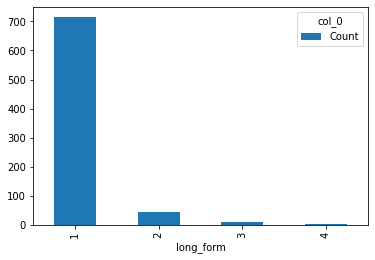

In [82]:
table = pd.crosstab(amb['long_form'], columns = 'Count')
table.plot.bar()
plt.show()

In [83]:
defin = amb[amb['long_form'] != 1]['short_form'].values.tolist()

In [84]:
train.shape

(4355, 6)

In [85]:
train = train[train['short_form'].isin(defin)]

In [86]:
train.shape

(953, 6)

Transform dataframe to a list of dictionaries

In [88]:
train_data = train[['doc_id', 'texto', 'short_form', 'long_form', 'StartOffset', 'EndOffset']].to_dict('records')

### Get the text before and after the SF

In [89]:
train_ndata, sf_not_found = get_f_b_context_text(train_data)

Check if any SF is not founded in the text

In [90]:
sf_not_found_set = set(sf_not_found)

In [91]:
len(sf_not_found_set)

0

Now clean the texts, remove string punctuation, accents, lower case, remove double spaces, separate numbers from sf

In [160]:
# def clean_text_after(data):
    
#     for instance in data:
#         instance[1] = clean_text(instance[1]).lower()
#         instance[2] = clean_text(instance[2]).lower()
#         instance[1] = re.sub(r'(\d+)', r'\g<1> ', instance[1]) #metemos espacio entre número y acrónimos que quedan pegados    
#         instance[2] = re.sub(r'(\d+)', r'\g<1> ', instance[2])
#         instance[1] = re.sub(r'\s+', ' ', instance[1]).strip()
#         instance[2] = re.sub(r'\s+', ' ', instance[2]).strip()
#     return data
        

In [161]:
# train_ndata = clean_text_after(train_ndata)

### Get the contexts 

From the texts before and after the sf, we limit the number of words

In [92]:
star_ends_tokens = 6 #number of tokens to add because <start> and <end> labels 

In [93]:
n_step_f = 10 + star_ends_tokens #number of words to select from the forward context
n_step_b = 10#number of words to select from the backward context

In [94]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/egarcia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [95]:
train_ndata = limit_context(train_ndata)

In [96]:
train_ndata[0]

['GPT',
 'bioquímicos en sangre eran normales salvo la GOT 87 , < start > GPT < end >',
 '51 , gamma-GT 67 y las proteínas totales que eran',
 'glutamic pyruvic transaminar']

### Transform into df grouped by LF

In [97]:
data_dic = create_dict(train_ndata)

In [98]:
data_df = pd.DataFrame(data_dic)

Asign an id to each LF

In [99]:
data_df = data_df.assign(id=(data_df['long_form']).astype('category').cat.codes)

In [100]:
data_df.head()

,short_form,context,long_form,id
0,GPT,"bioquímicos en sangre eran normales salvo la GOT 87 , < start > GPT < end > 51 , gamma-GT 67 y l...",glutamic pyruvic transaminar,63
1,C,"la delgadez ( IMC 17 ) , temperatura 37 º < start > C < end > tensión arterial 105/60 , se encon...",centimetro,24
2,C,"semanas , ingresó por cuadro de fiebre de 39 º < start > C < end > dolor y dificultad para movil...",centimetro,24
3,C,"la delgadez ( IMC 17 ) , temperatura 37 º < start > C < end > tensión arterial 105/60 , se encon...",centigrado,23
4,C,"semanas , ingresó por cuadro de fiebre de 39 º < start > C < end > dolor y dificultad para movil...",centigrado,23


In [101]:
data_df.shape

(953, 4)

Vamos a unir cada SF con todas las posibles LF, una por cada registro, para que posteriormente el modelo funcione de forma binaria asignando la probabilidad de que ese sea su LF

In [102]:
sf_lf_unique = data_df[['short_form', 'long_form']].drop_duplicates()

In [103]:
sf_lf_unique.shape

(122, 2)

In [104]:
sf_lf_unique.sort_values('short_form').head()

,short_form,long_form
347,A,adeniner
244,A,antigeno leucocitario humano
576,A,adenina
307,ALT,alanina aminotransferaso
200,ALT,alanine transferar


In [105]:
data_merged = data_df.merge(sf_lf_unique, on = 'short_form', how = 'left')

In [106]:
data_merged.shape

(2232, 5)

In [107]:
pd.set_option('display.max_colwidth', 100)

In [108]:
data_df.sort_values(['short_form', 'context']).head()

,short_form,context,long_form,id
576,A,"I , mutación Factor V Leiden , protrombina 20,210 G- < start > A < end > con resultado de normal...",adenina,0
347,A,el gen KIT de significado clínico desconocido [ c.2509G > < start > A < end > ( p.Ala837Thr ) ] ...,adeniner,1
244,A,"renal de donante fallecido , compartiendo un DR y un < start > A < end > con un tiempo de isquem...",antigeno leucocitario humano,11
450,ALT,91mg/dl ; bilirrubina total 21mg/dl ; AST 164 U/l ; < start > ALT < end > 103 U/l ; GGT 152 UI/d...,alanina aminotransferaso,3
446,ALT,"Globulinas 3.2 , Fosfatasa alcalina 255 , GGT 22 , < start > ALT < end > 49 , AST 65 , Glicemia ...",alanine transferar,5


In [109]:
data_merged.sort_values(['short_form', 'context']).head()

,short_form,context,long_form_x,id,long_form_y
1367,A,"I , mutación Factor V Leiden , protrombina 20,210 G- < start > A < end > con resultado de normal...",adenina,0,antigeno leucocitario humano
1368,A,"I , mutación Factor V Leiden , protrombina 20,210 G- < start > A < end > con resultado de normal...",adenina,0,adeniner
1369,A,"I , mutación Factor V Leiden , protrombina 20,210 G- < start > A < end > con resultado de normal...",adenina,0,adenina
830,A,el gen KIT de significado clínico desconocido [ c.2509G > < start > A < end > ( p.Ala837Thr ) ] ...,adeniner,1,antigeno leucocitario humano
831,A,el gen KIT de significado clínico desconocido [ c.2509G > < start > A < end > ( p.Ala837Thr ) ] ...,adeniner,1,adeniner


El label debe de ser 0 o 1, es decir, si la LF que le corresponde es la que se le asigna. Por ello creamos una etiqueta binaria.

In [110]:
def get_label(row):
    if row['long_form_x'] == row['long_form_y']:
        return 1
    else:
        return 0

In [111]:
data_merged['label'] = data_merged.apply(get_label, axis = 1)

In [112]:
data_merged.head()

,short_form,context,long_form_x,id,long_form_y,label
0,GPT,"bioquímicos en sangre eran normales salvo la GOT 87 , < start > GPT < end > 51 , gamma-GT 67 y l...",glutamic pyruvic transaminar,63,glutamic pyruvic transaminar,1
1,GPT,"bioquímicos en sangre eran normales salvo la GOT 87 , < start > GPT < end > 51 , gamma-GT 67 y l...",glutamic pyruvic transaminar,63,glutamate pyruvatar transaminar,0
2,C,"la delgadez ( IMC 17 ) , temperatura 37 º < start > C < end > tensión arterial 105/60 , se encon...",centimetro,24,centimetro,1
3,C,"la delgadez ( IMC 17 ) , temperatura 37 º < start > C < end > tensión arterial 105/60 , se encon...",centimetro,24,centigrado,0
4,C,"la delgadez ( IMC 17 ) , temperatura 37 º < start > C < end > tensión arterial 105/60 , se encon...",centimetro,24,cysteine,0


In [113]:
data_merged = data_merged[['short_form', 'context', 'long_form_y', 'label']]

In [114]:
data_merged = data_merged.rename(columns = {'long_form_y':'long_form'})

In [115]:
data_merged.reset_index(drop = True, inplace = True)

In [116]:
data_merged.head()

,short_form,context,long_form,label
0,GPT,"bioquímicos en sangre eran normales salvo la GOT 87 , < start > GPT < end > 51 , gamma-GT 67 y l...",glutamic pyruvic transaminar,1
1,GPT,"bioquímicos en sangre eran normales salvo la GOT 87 , < start > GPT < end > 51 , gamma-GT 67 y l...",glutamate pyruvatar transaminar,0
2,C,"la delgadez ( IMC 17 ) , temperatura 37 º < start > C < end > tensión arterial 105/60 , se encon...",centimetro,1
3,C,"la delgadez ( IMC 17 ) , temperatura 37 º < start > C < end > tensión arterial 105/60 , se encon...",centigrado,0
4,C,"la delgadez ( IMC 17 ) , temperatura 37 º < start > C < end > tensión arterial 105/60 , se encon...",cysteine,0


In [117]:
data_merged.to_csv('data/data_train/train_data_beto_10_amb_lfnorm.csv')

## Prepare Test Data

### Preprocessing

In [118]:
testing_raw.rename(columns={'nombre':'doc_id'}, inplace = True)

In [119]:
test = testing_raw.merge(testing_abbr[['doc_id', 'Abbreviation', 'Definition_lemmatized']], on = 'doc_id', how = 'left')

In [120]:
test = test.merge(testing_abbr, on = ['doc_id', 'Abbreviation'], how = 'left')

In [121]:
test = test.drop_duplicates()

In [122]:
test = test[['doc_id', 'texto', 'Abbreviation', 'Definition_lemmatized_x', 'StartOffset', 'EndOffset']]

In [123]:
test = test.rename(columns = {'Definition_lemmatized_x':'Definition'})

In [124]:
test.head()

,doc_id,texto,Abbreviation,Definition,StartOffset,EndOffset
0,S1130-01082008001000010-1,"Varón de 43 años originario de Marruecos, que ingresó en nuestro servicio por cuadro de 4 días d...",PAI,pancreatitis autoinmunir,2502.0,2505.0
1,S1130-01082008001000010-1,"Varón de 43 años originario de Marruecos, que ingresó en nuestro servicio por cuadro de 4 días d...",SLA,anti-soluble liver antiger,702.0,705.0
2,S1130-01082008001000010-1,"Varón de 43 años originario de Marruecos, que ingresó en nuestro servicio por cuadro de 4 días d...",SMA,smooth muscle actin,697.0,700.0
3,S1130-01082008001000010-1,"Varón de 43 años originario de Marruecos, que ingresó en nuestro servicio por cuadro de 4 días d...",LKM1,liver-kidney microsomal type 1,691.0,695.0
4,S1130-01082008001000010-1,"Varón de 43 años originario de Marruecos, que ingresó en nuestro servicio por cuadro de 4 días d...",ANCA,antineutrophil cytoplasmic antibodie,685.0,689.0


In [125]:
test = test.rename(columns = {'Abbreviation': 'short_form', 'Definition': 'long_form'})

In [126]:
test = test.dropna(subset = ['short_form', 'long_form'])

In [127]:
test[['StartOffset', 'EndOffset']] = test[['StartOffset', 'EndOffset']].astype(int)

Clean long forms to delete acents, string punctuation etc

In [128]:
test['long_form'] = test['long_form'].map(clean_text)

### Normalize long forms

In [129]:
sf_lf_test = test[['short_form', 'long_form']].drop_duplicates()

In [130]:
sf_lf_list_test = sf_lf_test.groupby('short_form', as_index=False).agg({'long_form': list})
sf_lf_list_test['len'] = sf_lf_list_test['long_form'].map(lambda x: len(x))
sf_lf_list_test.sort_values('len', ascending = False)

,short_form,long_form,len
87,C3,"[tercero componente complemento, tercero vertebra cervical, complemento 3, nivel c subnivel 3]",4
241,G,"[gauge, guanine, guanina]",3
215,F,"[filamentous, fenilalanina, french]",3
481,T,"[treonina, thymus, onda t]",3
416,PL,"[puncion lumbar, percepcion luz, periodo lavado]",3
...,...,...,...
252,GOT,[glutamic oxalic transaminar],1
253,GPL,[g fosfolipido],1
254,GPT,[glutamate pyruvatar transaminar],1
255,GQ-1b,[antigangliosidir antibodie 1b],1


#### Apply Levenshtein distance to normalize Long Forms

Get more frequent lf per sf

In [163]:
frec = test['long_form'].value_counts().reset_index()
frec

,index,long_form
0,miligramo,361
1,decilitro,213
2,centimetro,171
3,litro,128
4,mililitro,117
...,...,...
673,bloqueo rama derecho,1
674,colangiopancreatografia retrogrado endoscopico,1
675,human leukocyte antigir b2,1
676,sindrome alport,1


Create a dictionary where keys are the lf to normalize and the values the normalized form

In [166]:
norm_test = []
for i in sf_lf_list_test['long_form']:
    norm_test.append(normalize_lf(i))

In [167]:
norm_test = [i for i in norm_test if i != None]

In [168]:
norm_dict_test = {}
for i in norm_test:
    norm_dict_test.update(i)
#norm_dict

Finally normalize long forms over the dataframe

In [169]:
train.head()

,doc_id,texto,short_form,long_form,StartOffset,EndOffset
15,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",GPT,glutamic pyruvic transaminar,1594,1597
24,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",C,centimetro,1169,1170
25,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",C,centimetro,904,905
27,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",C,centigrado,1169,1170
28,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",C,centigrado,904,905


In [170]:
test = test.replace({"long_form": norm_dict_test})

In [171]:
train.head()

,doc_id,texto,short_form,long_form,StartOffset,EndOffset
15,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",GPT,glutamic pyruvic transaminar,1594,1597
24,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",C,centimetro,1169,1170
25,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",C,centimetro,904,905
27,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",C,centigrado,1169,1170
28,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",C,centigrado,904,905


### Get just ambigous acronyms

In [172]:
amb_test = test.groupby('short_form')['long_form'].nunique().reset_index().sort_values('long_form', ascending = False)

In [173]:
amb_test.head()

,short_form,long_form
87,C3,4
481,T,3
53,AV,3
215,F,3
416,PL,3


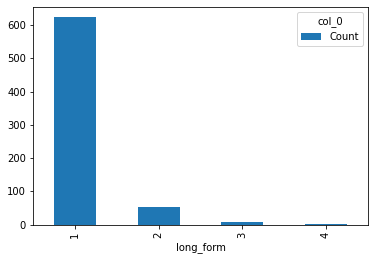

In [174]:
table = pd.crosstab(amb_test['long_form'], columns = 'Count')
table.plot.bar()
plt.show()

In [175]:
defin_test = amb_test[amb_test['long_form'] != 1]['short_form'].values.tolist()

In [176]:
test.shape

(3515, 6)

In [177]:
test = test[test['short_form'].isin(defin_test)]

In [178]:
test.shape

(792, 6)

Transform dataframe to a list of dictionaries

In [179]:
test_data = test[['doc_id', 'texto', 'short_form', 'long_form', 'StartOffset', 'EndOffset']].to_dict('records')

### Get the text before and after the SF

In [180]:
test_ndata, sf_not_found = get_f_b_context_text(test_data)

Check if any SF is not founded in the text

In [181]:
sf_not_found_set = set(sf_not_found)

In [182]:
len(sf_not_found_set)

0

Now clean the texts, remove string punctuation, accents, lower case, remove double spaces, separate numbers from sf

In [183]:
# def clean_text_after(data):
    
#     for instance in data:
#         instance[1] = clean_text(instance[1]).lower()
#         instance[2] = clean_text(instance[2]).lower()
#         instance[1] = re.sub(r'(\d+)', r'\g<1> ', instance[1]) #metemos espacio entre número y acrónimos que quedan pegados    
#         instance[2] = re.sub(r'(\d+)', r'\g<1> ', instance[2])
#         instance[1] = re.sub(r'\s+', ' ', instance[1]).strip()
#         instance[2] = re.sub(r'\s+', ' ', instance[2]).strip()
#     return data
        

In [184]:
# train_ndata = clean_text_after(train_ndata)

### Get the contexts 

From the texts before and after the sf, we limit the number of words

In [185]:
star_ends_tokens = 6 #number of tokens to add because <start> and <end> labels 

In [186]:
n_step_f = 10 + star_ends_tokens #number of words to select from the forward context
n_step_b = 10#number of words to select from the backward context

In [187]:
test_ndata = limit_context(test_ndata)

In [188]:
test_ndata[0]

['CA',
 'IgG 1840 UI/ml ( 751-1.560 UI/ml ) . El marcador < start > CA < end >',
 '19-9 era de 82 UI/ml . Los autoanticuerpos ( ANA',
 'carbohydrate antiger']

### Transform into df grouped by LF

In [189]:
data_dic = create_dict(test_ndata)

In [190]:
data_df = pd.DataFrame(data_dic)

Asign an id to each LF

In [191]:
data_df = data_df.assign(id=(data_df['long_form']).astype('category').cat.codes)

In [192]:
data_df.head()

,short_form,context,long_form,id
0,CA,IgG 1840 UI/ml ( 751-1.560 UI/ml ) . El marcador < start > CA < end > 19-9 era de 82 UI/ml . Los...,carbohydrate antiger,18
1,FA,"UI/ml , GPT 371 UI/ml , GGT 632 UI/ml , < start > FA < end > 787 UI/ml , LDH 394 UI/ml . Amilasa...",fosfatasa alcalino,63
2,mg,". La analítica mostró los siguientes datos : bilirrubina 19,44 < start > mg < end > dl , GOT 110...",miligramo,88
3,mg,inició tratamiento con corticoides ( metilprednisolona a dosis de 32 < start > mg < end > día ) ...,miligramo,88
4,F,"AMA-2 , ANCA , LKM1 , SMA , SLA y < start > F < end > actina ) y serologías para virus y bacteri...",filamentous,61


In [193]:
data_df.shape

(792, 4)

Vamos a unir cada SF con todas las posibles LF, una por cada registro, para que posteriormente el modelo funcione de forma binaria asignando la probabilidad de que ese sea su LF

In [194]:
sf_lf_unique = data_df[['short_form', 'long_form']].drop_duplicates()

In [195]:
sf_lf_unique.shape

(135, 2)

In [196]:
sf_lf_unique.sort_values('short_form').head()

,short_form,long_form
450,A,adenina
413,A,adeniner
719,AL,anestesico local
714,AL,amiloidosis primario
631,ALT,alanine aminotransferar


In [197]:
data_merged = data_df.merge(sf_lf_unique, on = 'short_form', how = 'left')

In [198]:
data_merged.shape

(1696, 5)

In [199]:
pd.set_option('display.max_colwidth', 100)

In [200]:
data_df.sort_values(['short_form', 'context']).head()

,short_form,context,long_form,id
413,A,dominante ( ATR-AD ) . Dicha mutación ( c.1766G > < start > A < end > fig . 2A ) supone la susti...,adeniner,1
450,A,la mutación 1691 G-A del factor V y 20210 G- < start > A < end > del factor II . El resto del es...,adenina,0
451,A,realizándose posteriormente una electroforesis que identificó la mutación 1691 G- < start > A < ...,adenina,0
714,AL,( EVA < 2 ) con la nueva concentración de < start > AL < end > El catéter epidural se retiró en ...,amiloidosis primario,6
719,AL,( EVA < 2 ) con la nueva concentración de < start > AL < end > El catéter epidural se retiró en ...,anestesico local,8


In [201]:
data_merged.sort_values(['short_form', 'context']).head()

,short_form,context,long_form_x,id,long_form_y
883,A,dominante ( ATR-AD ) . Dicha mutación ( c.1766G > < start > A < end > fig . 2A ) supone la susti...,adeniner,1,adeniner
884,A,dominante ( ATR-AD ) . Dicha mutación ( c.1766G > < start > A < end > fig . 2A ) supone la susti...,adeniner,1,adenina
973,A,la mutación 1691 G-A del factor V y 20210 G- < start > A < end > del factor II . El resto del es...,adenina,0,adeniner
974,A,la mutación 1691 G-A del factor V y 20210 G- < start > A < end > del factor II . El resto del es...,adenina,0,adenina
975,A,realizándose posteriormente una electroforesis que identificó la mutación 1691 G- < start > A < ...,adenina,0,adeniner


El label debe de ser 0 o 1, es decir, si la LF que le corresponde es la que se le asigna. Por ello creamos una etiqueta binaria.

In [202]:
def get_label(row):
    if row['long_form_x'] == row['long_form_y']:
        return 1
    else:
        return 0

In [203]:
data_merged['label'] = data_merged.apply(get_label, axis = 1)

In [204]:
data_merged.head()

,short_form,context,long_form_x,id,long_form_y,label
0,CA,IgG 1840 UI/ml ( 751-1.560 UI/ml ) . El marcador < start > CA < end > 19-9 era de 82 UI/ml . Los...,carbohydrate antiger,18,carbohydrate antiger,1
1,CA,IgG 1840 UI/ml ( 751-1.560 UI/ml ) . El marcador < start > CA < end > 19-9 era de 82 UI/ml . Los...,carbohydrate antiger,18,california,0
2,CA,IgG 1840 UI/ml ( 751-1.560 UI/ml ) . El marcador < start > CA < end > 19-9 era de 82 UI/ml . Los...,carbohydrate antiger,18,cancer antiger,0
3,FA,"UI/ml , GPT 371 UI/ml , GGT 632 UI/ml , < start > FA < end > 787 UI/ml , LDH 394 UI/ml . Amilasa...",fosfatasa alcalino,63,fosfatasa alcalino,1
4,FA,"UI/ml , GPT 371 UI/ml , GGT 632 UI/ml , < start > FA < end > 787 UI/ml , LDH 394 UI/ml . Amilasa...",fosfatasa alcalino,63,faceta articular,0


In [205]:
data_merged = data_merged[['short_form', 'context', 'long_form_y', 'label']]

In [206]:
data_merged = data_merged.rename(columns = {'long_form_y':'long_form'})

In [207]:
data_merged.reset_index(drop = True, inplace = True)

In [208]:
data_merged.head()

,short_form,context,long_form,label
0,CA,IgG 1840 UI/ml ( 751-1.560 UI/ml ) . El marcador < start > CA < end > 19-9 era de 82 UI/ml . Los...,carbohydrate antiger,1
1,CA,IgG 1840 UI/ml ( 751-1.560 UI/ml ) . El marcador < start > CA < end > 19-9 era de 82 UI/ml . Los...,california,0
2,CA,IgG 1840 UI/ml ( 751-1.560 UI/ml ) . El marcador < start > CA < end > 19-9 era de 82 UI/ml . Los...,cancer antiger,0
3,FA,"UI/ml , GPT 371 UI/ml , GGT 632 UI/ml , < start > FA < end > 787 UI/ml , LDH 394 UI/ml . Amilasa...",fosfatasa alcalino,1
4,FA,"UI/ml , GPT 371 UI/ml , GGT 632 UI/ml , < start > FA < end > 787 UI/ml , LDH 394 UI/ml . Amilasa...",faceta articular,0


In [211]:
data_merged.to_csv('data/data_train/test_data_beto_10_amb_lfnom.csv')